In [ ]:
# default_exp models.TSTPlus

# TSTPlus (Time Series Transformer)

> This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on TST (Zerveas, 2020) and Transformer (Vaswani, 2017).

**References:**

This is an unofficial PyTorch implementation by Ignacio Oguiza of  - oguiza@gmail.com based on:
* George Zerveas et al. A Transformer-based Framework for Multivariate Time Series Representation Learning, in Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD '21), August 14--18, 2021. ArXiV version: https://arxiv.org/abs/2010.02803
* Official implementation: https://github.com/gzerveas/mvts_transformer

```bash
@inproceedings{10.1145/3447548.3467401,
author = {Zerveas, George and Jayaraman, Srideepika and Patel, Dhaval and Bhamidipaty, Anuradha and Eickhoff, Carsten},
title = {A Transformer-Based Framework for Multivariate Time Series Representation Learning},
year = {2021},
isbn = {9781450383325},
publisher = {Association for Computing Machinery},
address = {New York, NY, USA},
url = {https://doi.org/10.1145/3447548.3467401},
doi = {10.1145/3447548.3467401},
booktitle = {Proceedings of the 27th ACM SIGKDD Conference on Knowledge Discovery &amp; Data Mining},
pages = {2114–2124},
numpages = {11},
keywords = {regression, framework, multivariate time series, classification, transformer, deep learning, self-supervised learning, unsupervised learning, imputation},
location = {Virtual Event, Singapore},
series = {KDD '21}
}
```

* Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). [Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)

* He, R., Ravula, A., Kanagal, B., & Ainslie, J. (2020). Realformer: Transformer Likes Informed Attention. arXiv preprint arXiv:2012.11747.

This implementation is adapted to work with the rest of the `tsai` library, and contain some hyperparameters that are not available in the original implementation. I included them for experimenting.

## Imports

In [ ]:
#export
from typing import Callable
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *
from tsai.data.core import *

## Positional encoders

In [ ]:
#export
def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model, device=default_device())
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10) 
    return pe.to(device=device)

SinCosPosEncoding = PositionalEncoding

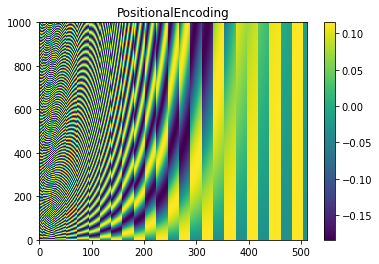

(5.438924e-10, 0.09999991, -0.18388666, 0.11518021, (1000, 512))

In [ ]:
pe = PositionalEncoding(1000, 512).detach().cpu().numpy()
plt.pcolormesh(pe, cmap='viridis')
plt.title('PositionalEncoding')
plt.colorbar()
plt.show()
pe.mean(), pe.std(), pe.min(), pe.max(), pe.shape

In [ ]:
#export
def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False, device=default_device()):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10) 
    return cpe.to(device=device)

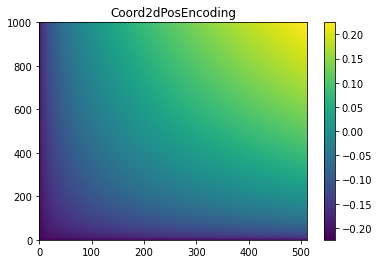

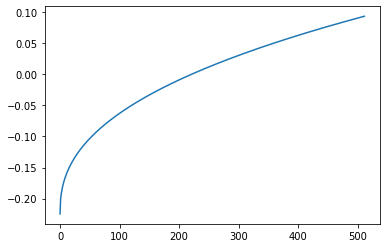

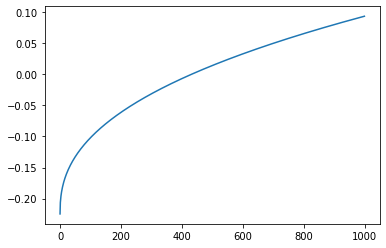

(3.695488e-09, 0.09999991, -0.22459325, 0.22487777)

In [ ]:
cpe = Coord2dPosEncoding(1000, 512, exponential=True, normalize=True).cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord2dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(0))
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max()

In [ ]:
#export
def Coord1dPosEncoding(q_len, exponential=False, normalize=True, device=default_device()):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10) 
    return cpe.to(device=device)

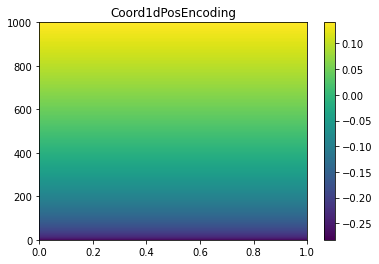

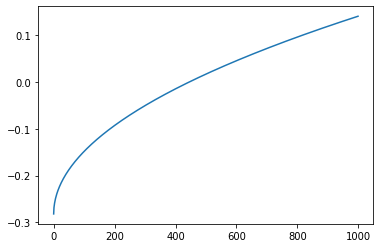

(0.0, 0.099949986, -0.2820423, 0.14113107, (1000, 1))

In [ ]:
cpe = Coord1dPosEncoding(1000, exponential=True, normalize=True).detach().cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord1dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max(), cpe.shape

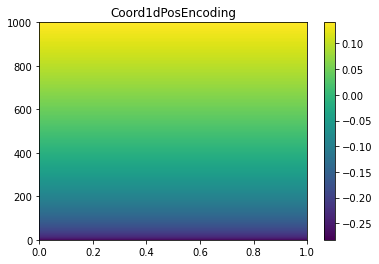

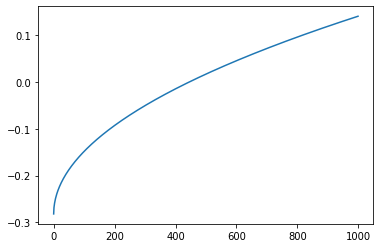

(0.0, 0.099949986, -0.2820423, 0.14113107)

In [ ]:
cpe = Coord1dPosEncoding(1000, exponential=True, normalize=True).detach().cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord1dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max()

## TST

In [ ]:
#exporti
def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')
    
class _TSTEncoderLayer(Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):

        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = ifnone(d_k, d_model // n_heads)
        d_v = ifnone(d_v, d_model // n_heads)

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else: 
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias), 
                                get_activation_fn(activation), 
                                nn.Dropout(dropout), 
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else: 
            self.norm_ffn = nn.LayerNorm(d_model)
        
        self.pre_norm = pre_norm
        self.store_attn = store_attn

    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn: 
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src

In [ ]:
t = torch.rand(16, 50, 128)
attn_mask = torch.triu(torch.ones(50, 50)) # shape: q_len x q_len
key_padding_mask = torch.zeros(16, 50)
key_padding_mask[[1, 3, 6, 15], -10:] = 1
key_padding_mask = key_padding_mask.bool()
print('attn_mask', attn_mask.shape, 'key_padding_mask', key_padding_mask.shape)
encoder = _TSTEncoderLayer(q_len=50, d_model=128, n_heads=8, d_k=None, d_v=None, d_ff=512, attn_dropout=0., dropout=0.1, store_attn=True, activation='gelu')
output = encoder(t, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
output.shape

attn_mask torch.Size([50, 50]) key_padding_mask torch.Size([16, 50])


torch.Size([16, 50, 128])

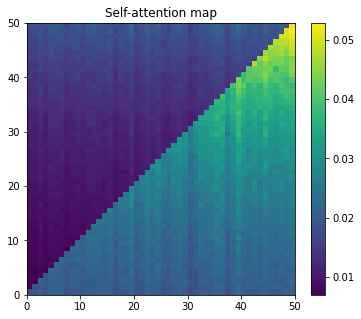

In [ ]:
cmap='viridis'
figsize=(6,5)
plt.figure(figsize=figsize)
plt.pcolormesh(encoder.attn[0][0].detach().cpu().numpy(), cmap=cmap)
plt.title('Self-attention map')
plt.colorbar()
plt.show()

In [ ]:
#exporti
class _TSTEncoder(Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu', 
                 res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        self.layers = nn.ModuleList([_TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, 
                                                      attn_dropout=attn_dropout, dropout=dropout, 
                                                      activation=activation, res_attention=res_attention, 
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:Tensor, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output

In [ ]:
#exporti
class _TSTBackbone(Module):
    def __init__(self, c_in, seq_len, max_seq_len=512,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True, verbose=False, **kwargs):

        # Input encoding
        q_len = seq_len
        self.new_q_len = False
        if max_seq_len is not None and seq_len > max_seq_len: # Control temporal resolution
            self.new_q_len = True
            q_len = max_seq_len
            tr_factor = math.ceil(seq_len / q_len)
            total_padding = (tr_factor * q_len - seq_len)
            padding = (total_padding // 2, total_padding - total_padding // 2)
            self.W_P = nn.Sequential(Pad1d(padding), Conv1d(c_in, d_model, kernel_size=tr_factor, padding=0, stride=tr_factor))
            pv(f'temporal resolution modified: {seq_len} --> {q_len} time steps: kernel_size={tr_factor}, stride={tr_factor}, padding={padding}.\n', verbose)
        elif kwargs:
            self.new_q_len = True
            t = torch.rand(1, 1, seq_len)
            q_len = Conv1d(1, 1, **kwargs)(t).shape[-1]
            self.W_P = Conv1d(c_in, d_model, **kwargs) # Eq 2
            pv(f'Conv1d with kwargs={kwargs} applied to input to create input encodings\n', verbose)
        else:
            self.W_P = nn.Linear(c_in, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = self._positional_encoding(pe, learn_pe, q_len, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = _TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout, 
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)
        self.transpose = Transpose(-1, -2, contiguous=True)
        self.key_padding_mask, self.padding_var, self.attn_mask = key_padding_mask, padding_var, attn_mask

    def forward(self, inp) -> Tensor:  
        r"""Pass the input through the TST backbone.
        Args:
            inp: input (optionally with padding mask. 1s (meaning padded) in padding mask will be ignored while 0s (non-padded) will be unchanged.)
        Shape:
            There are 3 options: 
            1. inp: Tensor containing just time series data [bs x nvars x q_len] 
            2. inp: Tensor containing time series data plus a padding feature in the last channel [bs x (nvars + 1) x q_len]
            3. inp: tuple containing a tensor with time series data plus a padding mask per batch ([bs x nvars x q_len] , [bs x q_len] )
        """

        # x and padding mask
        if isinstance(inp, tuple): x, key_padding_mask = inp
        elif self.key_padding_mask == 'auto': x, key_padding_mask = self._key_padding_mask(inp) # automatically identify padding mask
        elif self.key_padding_mask == -1: x, key_padding_mask = inp[:, :-1], inp[:, -1]         # padding mask is the last channel
        else: x, key_padding_mask = inp, None

        # Input encoding
        if self.new_q_len: u = self.W_P(x).transpose(2,1) # Eq 2        # u: [bs x d_model x q_len] transposed to [bs x q_len x d_model]
        else: u = self.W_P(x.transpose(2,1))              # Eq 1        # u: [bs x q_len x nvars] converted to [bs x q_len x d_model]

        # Positional encoding
        u = self.dropout(u + self.W_pos)

        # Encoder
        z = self.encoder(u, key_padding_mask=key_padding_mask, attn_mask=self.attn_mask)    # z: [bs x q_len x d_model]
        z = self.transpose(z)                                                               # z: [bs x d_model x q_len]
        if key_padding_mask is not None: 
            z = z * torch.logical_not(key_padding_mask.unsqueeze(1))  # zero-out padding embeddings
        return z

    def _positional_encoding(self, pe, learn_pe, q_len, d_model):
        # Positional encoding
        if pe == None:
            W_pos = torch.empty((q_len, d_model), device=default_device()) # pe = None and learn_pe = False can be used to measure impact of pe
            nn.init.uniform_(W_pos, -0.02, 0.02)
            learn_pe = False
        elif pe == 'zero': 
            W_pos = torch.empty((q_len, 1), device=default_device())
            nn.init.uniform_(W_pos, -0.02, 0.02)
        elif pe == 'zeros': 
            W_pos = torch.empty((q_len, d_model), device=default_device())
            nn.init.uniform_(W_pos, -0.02, 0.02)
        elif pe == 'normal' or pe == 'gauss':
            W_pos = torch.zeros((q_len, 1), device=default_device())
            torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
        elif pe == 'uniform':
            W_pos = torch.zeros((q_len, 1), device=default_device())
            nn.init.uniform_(W_pos, a=0.0, b=0.1)
        elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
        elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
        elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
        elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
        elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
        else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
            'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
        return nn.Parameter(W_pos, requires_grad=learn_pe)

    def _key_padding_mask(self, x):
        if self.padding_var is not None:
            mask = TSMaskTensor(x[:, self.padding_var] == 1)            # key_padding_mask: [bs x q_len]
            return x, mask
        else:
            mask = torch.isnan(x)
            x[mask] = 0
            if mask.any():
                mask = TSMaskTensor((mask.float().mean(1)==1).bool())   # key_padding_mask: [bs x q_len]
                return x, mask
            else:
                return x, None

In [ ]:
# export
class TSTPlus(nn.Sequential):
    """TST (Time Series Transformer) is a Transformer that takes continuous time series as inputs"""
    def __init__(self, c_in:int, c_out:int, seq_len:int, max_seq_len:Optional[int]=512,
                 n_layers:int=3, d_model:int=128, n_heads:int=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0., act:str="gelu", key_padding_mask:bool='auto', 
                 padding_var:Optional[int]=None, attn_mask:Optional[Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, flatten:bool=True, fc_dropout:float=0.,
                 concat_pool:bool=False, bn:bool=False, custom_head:Optional[Callable]=None,
                 y_range:Optional[tuple]=None, verbose:bool=False, **kwargs):
        """
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset.
            c_out: the number of target classes.
            seq_len: number of time steps in the time series.
            max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default=512.
            d_model: total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
            n_heads:  parallel attention heads. Default:16 (range(8-16)).
            d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_ff: the dimension of the feedforward network model. Default: 512 (range(256-512))
            norm: flag to indicate whether BatchNorm (default) or LayerNorm is used in the encoder layers.
            attn_dropout: dropout applied to the attention scores
            dropout: amount of dropout applied to all linear layers except q,k&v projections in the encoder.
            act: the activation function of intermediate layer, relu or gelu.
            key_padding_mask:   a boolean padding mask will be applied to attention if 'auto' a mask to those steps in a sample where all features are nan.
                                Other options include: True -->tuple (x, key_padding_mask), -1 --> key_padding_mask is the last channel, False: no mask.
            padding_var: (optional) an int indicating the variable that contains the padded steps (0: non-padded, 1: padded). 
            attn_mask: a boolean mask will be applied to attention if a tensor of shape [min(seq_len, max_seq_len) x min(seq_len, max_seq_len)] if provided.
            res_attention: if True Residual MultiheadAttention is applied.
            pre_norm: if True normalization will be applied as the first step in the sublayers. Defaults to False
            store_attn: can be used to visualize attention weights. Default: False.
            n_layers: number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
            pe: type of positional encoder.
                Available types (for experimenting): None, 'exp1d', 'lin1d', 'exp2d', 'lin2d', 'sincos', 'gauss' or 'normal',
                'uniform', 'zero', 'zeros' (default, as in the paper).
            learn_pe: learned positional encoder (True, default) or fixed positional encoder.
            flatten: this will flatten the encoder output to be able to apply an mlp type of head (default=False)
            fc_dropout: dropout applied to the final fully connected layer.
            concat_pool: indicates if global adaptive concat pooling will be used instead of global adaptive pooling.
            bn: indicates if batchnorm will be applied to the head.
            custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function)
            y_range: range of possible y values (used in regression tasks).
            kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.
        Input shape:
            x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
            attn_mask: q_len x q_len
            As mentioned in the paper, the input must be standardized by_var based on the entire training set.
        """
        # Backbone
        backbone = _TSTBackbone(c_in, seq_len=seq_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, 
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn, 
                                pe=pe, learn_pe=learn_pe, verbose=verbose, **kwargs)

        # Head
        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = backbone.seq_len
        if custom_head: head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else: head = self.create_head(self.head_nf, c_out, self.seq_len, act=act, flatten=flatten, concat_pool=concat_pool,
                                           fc_dropout=fc_dropout, bn=bn, y_range=y_range)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))


    def create_head(self, nf, c_out, seq_len, flatten=True, concat_pool=False, act="gelu", fc_dropout=0., bn=False, y_range=None):
        layers = [get_activation_fn(act)]
        if flatten:
            nf *= seq_len
            layers += [Flatten()]
        else:
            if concat_pool: nf *= 2
            layers = [GACP1d(1) if concat_pool else GAP1d(1)]
        layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)


    def show_pe(self, cmap='viridis', figsize=None):
        plt.figure(figsize=figsize)
        plt.pcolormesh(self.backbone.W_pos.detach().cpu().T, cmap=cmap)
        plt.title('Positional Encoding')
        plt.colorbar()
        plt.show()
        plt.figure(figsize=figsize)
        plt.title('Positional Encoding - value along time axis')
        plt.plot(F.relu(self.backbone.W_pos.data).mean(1).cpu())
        plt.plot(-F.relu(-self.backbone.W_pos.data).mean(1).cpu())
        plt.show()

In [ ]:
from tsai.models.utils import build_ts_model

bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 1_500

xb = torch.randn(bs, c_in, seq_len).to(device)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 256
d_model = 128
n_heads = 16
d_k = d_v = None  # if None --> d_model // n_heads
d_ff = 256
norm = "BatchNorm"
dropout = 0.1
activation = "gelu"
n_layers = 3
fc_dropout = 0.1
pe = None
learn_pe = True
kwargs = {}

model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
                d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, dropout=dropout, activation=activation, n_layers=n_layers,
                fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs).to(device)
test_eq(model(xb).shape, [bs, c_out])
test_eq(model[0], model.backbone)
test_eq(model[1], model.head)
model2 = build_ts_model(TSTPlus, c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
                           d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, dropout=dropout, activation=activation, n_layers=n_layers,
                           fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs).to(device)
test_eq(model2(xb).shape, [bs, c_out])
test_eq(model2[0], model2.backbone)
test_eq(model2[1], model2.head)
print(f'model parameters: {count_parameters(model)}')

model parameters: 470018


In [ ]:
key_padding_mask = torch.sort(torch.randint(0, 2, (bs, max_seq_len))).values.bool().to(device)
key_padding_mask[0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
model2.key_padding_mask = True
model2.to(device)((xb, key_padding_mask)).shape

torch.Size([8, 2])

In [ ]:
model.head

Sequential(
  (0): GELU()
  (1): Flatten(full=False)
  (2): LinBnDrop(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=32768, out_features=2, bias=True)
  )
)

In [ ]:
model = TSTPlus(c_in, c_out, seq_len, pre_norm=True)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])

In [ ]:
bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 5000

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

model = TSTPlus(c_in, c_out, seq_len, res_attention=True)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 605698


In [ ]:
custom_head = partial(create_pool_head, concat_pool=True)
model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, activation=activation, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, flatten=False, custom_head=custom_head, **kwargs)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 421122


In [ ]:
custom_head = partial(create_pool_plus_head, concat_pool=True)
model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, activation=activation, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, flatten=False, custom_head=custom_head, **kwargs)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 554240


In [ ]:
bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 60

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 120
d_model = 128
n_heads = 16
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
dropout = 0.1
act = "gelu"
n_layers = 3
fc_dropout = 0.1
pe='zeros'
learn_pe=True
kwargs = {}
# kwargs = dict(kernel_size=5, padding=2)

model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, act=act, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs)
test_eq(model.to(xb.device)(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')
body, head = model[0], model[1]
test_eq(body.to(xb.device)(xb).ndim, 3)
test_eq(head.to(xb.device)(body.to(xb.device)(xb)).ndim, 2)
head

model parameters: 421762


Sequential(
  (0): GELU()
  (1): Flatten(full=False)
  (2): LinBnDrop(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=7680, out_features=2, bias=True)
  )
)

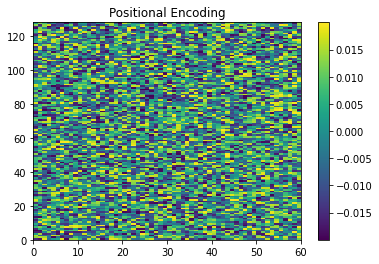

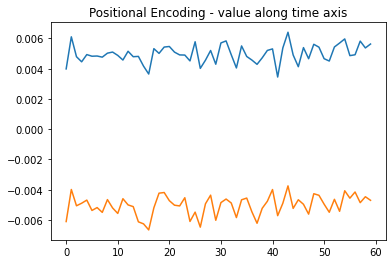

In [ ]:
model.show_pe()

In [ ]:
model = TSTPlus(3, 2, 10)
xb = torch.randn(4, 3, 10)
yb = torch.randint(0, 2, (4,))
test_eq(model.backbone._key_padding_mask(xb)[1], None)
random_idxs = np.random.choice(len(xb), 2, False)
xb[random_idxs, :, -5:] = np.nan
xb[random_idxs, 0, 1] = np.nan
test_eq(model.backbone._key_padding_mask(xb.clone())[1].data, (torch.isnan(xb).float().mean(1)==1).bool())
test_eq(model.backbone._key_padding_mask(xb.clone())[1].data.shape, (4,10))
print(torch.isnan(xb).sum())
pred = model.to(xb.device)(xb.clone())
loss = CrossEntropyLossFlat()(pred, yb)
loss.backward()
model.to(xb.device).backbone._key_padding_mask(xb)[1].data.shape

tensor(32)


torch.Size([4, 10])

In [ ]:
bs = 4
c_in = 3
seq_len = 10
c_out = 2
xb = torch.randn(bs, c_in, seq_len)
xb[:, -1] = torch.randint(0, 2, (bs, seq_len)).sort()[0]
model = TSTPlus(c_in, c_out, seq_len).to(xb.device)
test_eq(model.backbone._key_padding_mask(xb)[1], None)
model = TSTPlus(c_in, c_out, seq_len, padding_var=-1).to(xb.device)
test_eq(model.backbone._key_padding_mask(xb)[1], (xb[:, -1]==1))
model = TSTPlus(c_in, c_out, seq_len, padding_var=2).to(xb.device)
test_eq(model.backbone._key_padding_mask(xb)[1], (xb[:, -1]==1))
test_eq(model(xb).shape, (bs, c_out))

In [ ]:
#export
@delegates(TSTPlus.__init__)
class MultiTSTPlus(nn.Sequential):
    _arch = TSTPlus
    def __init__(self, feat_list, c_out, seq_len, max_seq_len:Optional[int]=512, custom_head=None, **kwargs):
        r"""
        MultiTST is a class that allows you to create a model with multiple branches of TST.
        
        Args:
            * feat_list: list with number of features that will be passed to each body, or list of list with feature indices.
        """
        self.feat_list = [feat_list] if isinstance(feat_list, int) else feat_list 
        self.device = ifnone(device, default_device())
        
        # Backbone
        branches = nn.ModuleList()
        self.head_nf = 0
        for feat in self.feat_list:
            if is_listy(feat): feat = len(feat)
            m = build_ts_model(self._arch, c_in=feat, c_out=c_out, seq_len=seq_len, max_seq_len=max_seq_len, **kwargs)
            with torch.no_grad(): 
                self.head_nf += m[0](torch.randn(1, feat, ifnone(seq_len, 10)).to(self.device)).shape[1]
            branches.append(m.backbone)
        backbone = _Splitter(self.feat_list, branches)
        
        # Head
        self.c_out = c_out
        q_len = min(seq_len, max_seq_len)
        self.seq_len = q_len 
        if custom_head is None:
            head = self._arch.create_head(self, self.head_nf, c_out, q_len)
        else: 
            head = custom_head(self.head_nf, c_out, q_len)
    
        layers = OrderedDict([('backbone', nn.Sequential(backbone)), ('head', nn.Sequential(head))])
        super().__init__(layers)
        self.to(self.device)

In [ ]:
#exporti
class _Splitter(Module):
    def __init__(self, feat_list, branches):
        self.feat_list, self.branches = feat_list, branches
    def forward(self, x):
        if is_listy(self.feat_list[0]): 
            x = [x[:, feat] for feat in self.feat_list]
        else: 
            x = torch.split(x, self.feat_list, dim=1)
        _out = []
        for xi, branch in zip(x, self.branches): _out.append(branch(xi))
        output = torch.cat(_out, dim=1)
        return output

In [ ]:
bs = 8
c_in = 7  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 10
xb2 = torch.randn(bs, c_in, seq_len)
model1 = MultiTSTPlus([2, 5], c_out, seq_len)
model2 = MultiTSTPlus(7, c_out, seq_len)
test_eq(model1.to(xb2.device)(xb2).shape, (bs, c_out))
test_eq(model1.to(xb2.device)(xb2).shape, model2.to(xb2.device)(xb2).shape)
test_eq(count_parameters(model1) > count_parameters(model2), True)

In [ ]:
bs = 8
c_in = 7  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 10
xb2 = torch.randn(bs, c_in, seq_len)
model1 = MultiTSTPlus([2, 5], c_out, seq_len, )
model2 = MultiTSTPlus([[0,2,5], [0,1,3,4,6]], c_out, seq_len)
test_eq(model1.to(xb2.device)(xb2).shape, (bs, c_out))
test_eq(model1.to(xb2.device)(xb2).shape, model2.to(xb2.device)(xb2).shape)

In [ ]:
model1 = MultiTSTPlus([2, 5], c_out, seq_len, y_range=(0.5, 5.5))
body, head = split_model(model1)
test_eq(body.to(xb2.device)(xb2).ndim, 3)
test_eq(head.to(xb2.device)(body.to(xb2.device)(xb2)).ndim, 2)
head

Sequential(
  (0): Sequential(
    (0): GELU()
    (1): Flatten(full=False)
    (2): LinBnDrop(
      (0): Linear(in_features=2560, out_features=2, bias=True)
    )
  )
)

In [ ]:
model = MultiTSTPlus([2, 5], c_out, seq_len, pre_norm=True)

In [ ]:
bs = 8
n_vars = 3
seq_len = 12
c_out = 2
xb = torch.rand(bs, n_vars, seq_len)
net = MultiTSTPlus(n_vars, c_out, seq_len)
change_model_head(net, create_pool_plus_head, concat_pool=False)
print(net.to(xb.device)(xb).shape)
net.head

torch.Size([8, 2])


Sequential(
  (0): AdaptiveAvgPool1d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
bs = 8
n_vars = 3
seq_len = 12
c_out = 10
xb = torch.rand(bs, n_vars, seq_len)
new_head = partial(conv_lin_nd_head, d=(5 ,2))
net = MultiTSTPlus(n_vars, c_out, seq_len, custom_head=new_head)
print(net.to(xb.device)(xb).shape)
net.head

torch.Size([8, 5, 2, 10])


Sequential(
  (0): create_conv_lin_nd_head(
    (0): Conv1d(128, 10, kernel_size=(1,), stride=(1,))
    (1): Linear(in_features=12, out_features=10, bias=True)
    (2): Transpose(-1, -2)
    (3): Reshape(bs, 5, 2, 10)
  )
)

In [ ]:
#hide
from tsai.imports import *
from tsai.export import *
nb_name = get_nb_name()
# nb_name = "108c_models.TSTPlus.ipynb"
create_scripts(nb_name);

<IPython.core.display.Javascript object>

108c_models.TSTPlus.ipynb saved at 2022-02-28 13:46:20.
Converted 108c_models.TSTPlus.ipynb.


Correct conversion! 😃
Total time elapsed 0.161 s
Monday 28/02/22 13:46:24 CET
